### Logistic Regression on Escherichia coli

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import StratifiedGroupKFold, KFold
from sklearn.decomposition import PCA

In [2]:
ecoli = pd.read_csv('/Users/alexandra/Desktop/thesis_programming/final_Ecoli.csv')

/var/folders/mx/knhr23fd09g19g__8gz1fgxh0000gn/T/ipykernel_11591/608710242.py:1: DtypeWarning: Columns (530424) have mixed types. Specify dtype option on import or set low_memory=False.
  ecoli = pd.read_csv('/Users/alexandra/Desktop/thesis_programming/final_Ecoli.csv')


In [3]:
ecoli.shape

(600, 530425)

In [4]:
snp_columns = ecoli.filter(like='SNP')
snp_columns.shape

(600, 501457)

In [7]:
# Separate feature columns and target labels
X_noST = ecoli.drop(columns=['TMP',"CTX","SUL","sample_ID","ST"], errors='ignore')

# Create individual datasets per antibiotic
# ecolilit into features and labels
ecoli_tmp = X_noST.copy()
ecoli_tmp['label'] = ecoli['TMP']
y_noST_tmp = ecoli_tmp['label']

ecoli_ctx = X_noST.copy()
ecoli_ctx['label'] = ecoli['CTX']
y_noST_ctx = ecoli_ctx['label']

ecoli_sul = X_noST.copy()
ecoli_sul['label'] = ecoli['SUL']
y_noST_sul = ecoli_sul['label']

### Classes visualization

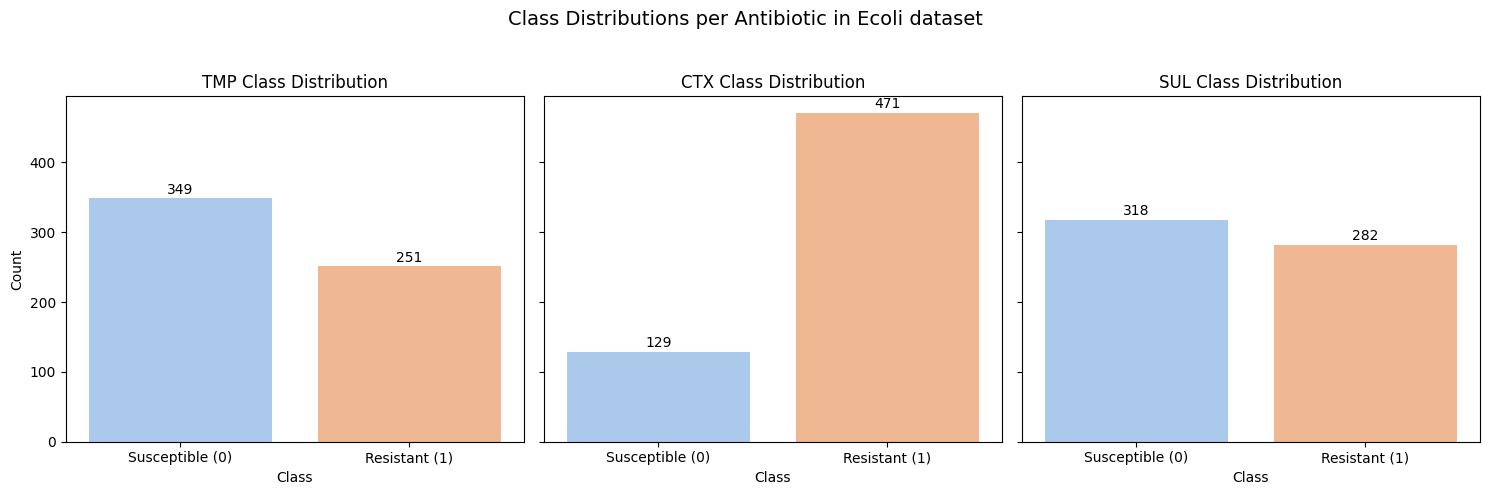

In [4]:
# Store your labels in a dictionary
labels_dict = {
    'TMP': y_noST_tmp,
    'CTX': y_noST_ctx,
    'SUL': y_noST_sul,
}

# Set up subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Plot each antibiotic
for ax, (name, y) in zip(axes, labels_dict.items()):
    sns.countplot(x=y, palette='pastel', ax=ax, hue=y)
    ax.set_title(f"{name} Class Distribution", fontsize=12)
    ax.set_xlabel("Class")
    ax.set_ylabel("Count" if name == 'TMP' else "")  # Only show y-axis on first
    ax.set_xticks([0, 1], ['Susceptible (0)', 'Resistant (1)'])
    ax.get_legend().remove()

    # Annotate counts
    for p in ax.patches:
        count = int(p.get_height())
        if count > 0:
            ax.annotate(f'{count}', (p.get_x() + p.get_width() / 2., count + 2),
                        ha='center', va='bottom', fontsize=10)


# Overall plot formatting
plt.suptitle("Class Distributions per Antibiotic in Ecoli dataset", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show()


### Blocked cross-validation

In [4]:
# Creating dictionary of parameters to tune
hparam = {"C":[0.001, 0.01, 0.1, 1.00]}

# Drop label columns
features = ecoli.drop(columns=["TMP", "CTX", "SUL", "sample_ID"], errors='ignore')

# drop rows with no numeric ST values
features['ST'] = pd.to_numeric(features['ST'], errors='coerce')  
features_clean_ST = features.dropna(subset=['ST'])

In [5]:
# Creating function to perform hyper parameter tuning of model
def LG_hp_tune(param, feat_train_df, lab_train, v=3, cv=4):
  #creating logistic regression model
  model = LogisticRegression(random_state = 42, max_iter=1000, class_weight='balanced')

  # isolating the features used for training
  feat = feat_train_df.drop(columns=["ST"])
  
  # Grouped cross-validation
  groups = feat_train_df['ST']
  cv = StratifiedGroupKFold(n_splits=4)
  gs = GridSearchCV(model, param, scoring='f1_macro',cv=cv, refit='f1_macro', verbose=v, return_train_score=True)
  gs.fit(feat, lab_train, groups=groups)

  print(gs.best_params_)
  print(gs.best_score_)
  return gs.best_estimator_

##### 1. TMP

In [14]:
# Align labels with the cleaned features
labels_tmp = ecoli.loc[features_clean_ST.index, 'TMP'] 

features_clean_ST['label'] = labels_tmp

# Define X and y properly
X_tmp = features_clean_ST.drop(columns=['label'])
y_tmp = features_clean_ST['label']

# Split the data
X_train_tmp, X_test_tmp, y_train_tmp, y_test_tmp = train_test_split(
    X_tmp, y_tmp, stratify=y_tmp, test_size=0.3, random_state=42)

smote = SMOTE(random_state=42)
X_train_resampled_tmp_clean_ST, y_train_resampled_tmp_clean_ST = smote.fit_resample(X_train_tmp, y_train_tmp)


/var/folders/mx/knhr23fd09g19g__8gz1fgxh0000gn/T/ipykernel_58584/893459752.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_clean_ST['label'] = labels_tmp


In [9]:
LG_tuned_tmp = LG_hp_tune(hparam, X_train_resampled_tmp_clean_ST, y_train_resampled_tmp_clean_ST)
bestC_tmp = LG_tuned_tmp.get_params()['C']

Fitting 4 folds for each of 4 candidates, totalling 16 fits
[CV 1/4] END .......C=0.001;, score=(train=0.947, test=0.789) total time=  33.3s
[CV 2/4] END .......C=0.001;, score=(train=0.965, test=0.709) total time=  31.7s
[CV 3/4] END .......C=0.001;, score=(train=0.977, test=0.728) total time=  25.2s
[CV 4/4] END .......C=0.001;, score=(train=0.959, test=0.727) total time=  27.7s
[CV 1/4] END ........C=0.01;, score=(train=1.000, test=0.824) total time=  39.9s
[CV 2/4] END ........C=0.01;, score=(train=1.000, test=0.690) total time=  35.3s
[CV 3/4] END ........C=0.01;, score=(train=1.000, test=0.772) total time=  34.9s
[CV 4/4] END ........C=0.01;, score=(train=1.000, test=0.761) total time=  39.9s
[CV 1/4] END .........C=0.1;, score=(train=1.000, test=0.833) total time=  43.6s
[CV 2/4] END .........C=0.1;, score=(train=1.000, test=0.690) total time=  44.3s
[CV 3/4] END .........C=0.1;, score=(train=1.000, test=0.763) total time=  47.9s
[CV 4/4] END .........C=0.1;, score=(train=1.000,

##### 2. CTX

In [10]:
# Align labels with the cleaned features
labels_ctx = ecoli.loc[features_clean_ST.index, 'CTX'] 

features_clean_ST['label'] = labels_ctx

# Define X and y properly
X_ctx = features_clean_ST.drop(columns=['label'])
y_ctx = features_clean_ST['label']

# Split the data
X_train_ctx, X_test_ctx, y_train_ctx, y_test_ctx = train_test_split(
    X_ctx, y_ctx, stratify=y_ctx, test_size=0.3, random_state=42)

smote = SMOTE(random_state=42, sampling_strategy='not majority')
X_train_resampled_ctx_clean_ST, y_train_resampled_ctx_clean_ST = smote.fit_resample(X_train_ctx, y_train_ctx)


/var/folders/mx/knhr23fd09g19g__8gz1fgxh0000gn/T/ipykernel_84931/3222288229.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_clean_ST['label'] = labels_ctx


In [11]:
LG_tuned_ctx = LG_hp_tune(hparam, X_train_resampled_ctx_clean_ST, y_train_resampled_ctx_clean_ST)
bestC_ctx = LG_tuned_ctx.get_params()['C']

Fitting 4 folds for each of 4 candidates, totalling 16 fits
[CV 1/4] END ....C=0.001; f1_macro: (train=0.991, test=0.891) total time=  37.0s
[CV 2/4] END ....C=0.001; f1_macro: (train=0.989, test=0.868) total time=  29.6s
[CV 3/4] END ....C=0.001; f1_macro: (train=0.989, test=0.953) total time=  29.6s
[CV 4/4] END ....C=0.001; f1_macro: (train=0.976, test=1.000) total time=  33.8s
[CV 1/4] END .....C=0.01; f1_macro: (train=1.000, test=0.898) total time=  34.0s
[CV 2/4] END .....C=0.01; f1_macro: (train=0.998, test=0.899) total time=  36.0s
[CV 3/4] END .....C=0.01; f1_macro: (train=0.996, test=0.946) total time=  34.3s
[CV 4/4] END .....C=0.01; f1_macro: (train=0.998, test=1.000) total time=  26.8s
[CV 1/4] END ......C=0.1; f1_macro: (train=1.000, test=0.888) total time=  24.8s
[CV 2/4] END ......C=0.1; f1_macro: (train=1.000, test=0.875) total time=  23.8s
[CV 3/4] END ......C=0.1; f1_macro: (train=1.000, test=0.953) total time=  30.4s
[CV 4/4] END ......C=0.1; f1_macro: (train=1.000,

##### 3. SUL

In [12]:
# Align labels with the cleaned features
labels_sul = ecoli.loc[features_clean_ST.index, 'SUL'] 

features_clean_ST['label'] = labels_sul

# Define X and y properly
X_sul = features_clean_ST.drop(columns=['label'])
y_sul = features_clean_ST['label']

# Split the data
X_train_sul, X_test_sul, y_train_sul, y_test_sul = train_test_split(
    X_sul, y_sul, stratify=y_sul, test_size=0.3, random_state=42)

# no smote because the data is almost balanced

/var/folders/mx/knhr23fd09g19g__8gz1fgxh0000gn/T/ipykernel_84931/3681589772.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_clean_ST['label'] = labels_sul


In [13]:
LG_tuned_sul = LG_hp_tune(hparam, X_train_sul, y_train_sul)
bestC_sul = LG_tuned_sul.get_params()['C']

Fitting 4 folds for each of 4 candidates, totalling 16 fits
[CV 1/4] END ....C=0.001; f1_macro: (train=0.955, test=0.757) total time=   7.7s
[CV 2/4] END ....C=0.001; f1_macro: (train=0.966, test=0.745) total time=   6.8s
[CV 3/4] END ....C=0.001; f1_macro: (train=0.970, test=0.735) total time=   7.1s
[CV 4/4] END ....C=0.001; f1_macro: (train=0.963, test=0.652) total time=   6.7s
[CV 1/4] END .....C=0.01; f1_macro: (train=1.000, test=0.778) total time=   9.0s
[CV 2/4] END .....C=0.01; f1_macro: (train=1.000, test=0.817) total time=   9.5s
[CV 3/4] END .....C=0.01; f1_macro: (train=1.000, test=0.745) total time=   9.1s
[CV 4/4] END .....C=0.01; f1_macro: (train=0.997, test=0.673) total time=   9.4s
[CV 1/4] END ......C=0.1; f1_macro: (train=1.000, test=0.798) total time=  10.4s
[CV 2/4] END ......C=0.1; f1_macro: (train=1.000, test=0.838) total time=  10.0s
[CV 3/4] END ......C=0.1; f1_macro: (train=1.000, test=0.765) total time=   9.6s
[CV 4/4] END ......C=0.1; f1_macro: (train=1.000,

### Training with best C and testing

In [8]:
# Train-test split
X_train_tmp, X_test_tmp, y_train_tmp, y_test_tmp = train_test_split(
    X_noST, y_noST_tmp, stratify= y_noST_tmp, test_size=0.3, random_state=42)

X_train_ctx, X_test_ctx, y_train_ctx, y_test_ctx = train_test_split(
    X_noST, y_noST_ctx, stratify= y_noST_ctx, test_size=0.3, random_state=42)

X_train_sul, X_test_sul, y_train_sul, y_test_sul = train_test_split(
    X_noST, y_noST_sul, stratify= y_noST_sul, test_size=0.3, random_state=42)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled_tmp, y_train_resampled_tmp = smote.fit_resample(X_train_tmp, y_train_tmp)
X_train_resampled_ctx, y_train_resampled_ctx = smote.fit_resample(X_train_ctx, y_train_ctx) 

print("TMP Resampled Class Distribution:", Counter(y_train_resampled_tmp))
print("CTX Resampled Class Distribution:", Counter(y_train_resampled_ctx))
print("SUL Class Distribution:", Counter(y_train_sul))


TMP Resampled Class Distribution: Counter({0: 244, 1: 244})
CTX Resampled Class Distribution: Counter({0: 330, 1: 330})
SUL Class Distribution: Counter({0: 223, 1: 197})


##### 1. TMP

Accuracy on test set: 0.7444
Accuracy on training set: 1.0000
              precision    recall  f1-score   support

           0       0.77      0.80      0.79       105
           1       0.70      0.67      0.68        75

    accuracy                           0.74       180
   macro avg       0.74      0.73      0.73       180
weighted avg       0.74      0.74      0.74       180



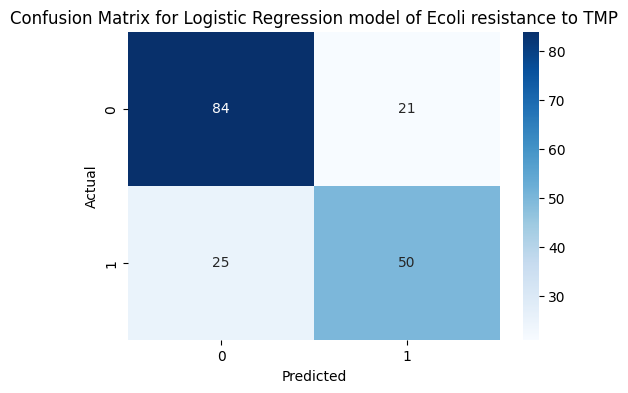

ROC-AUC on test set: 0.845


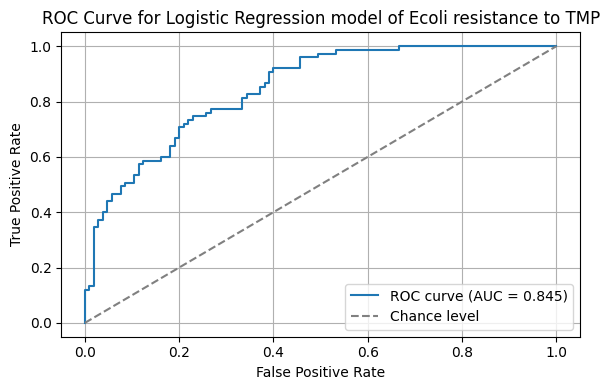

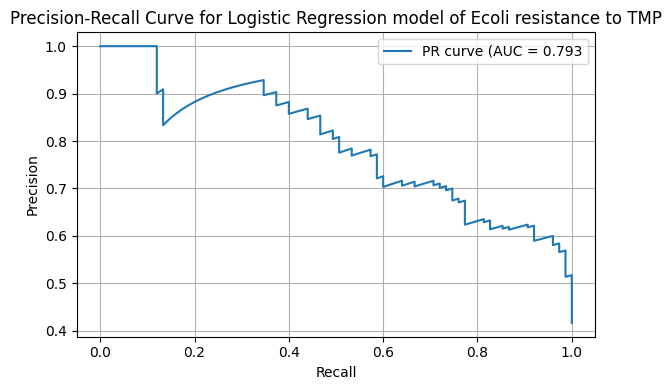

In [9]:
model_tmp = LogisticRegression(max_iter=500, random_state=42, C=1, class_weight='balanced')

# Train the model
model_tmp.fit(X_train_resampled_tmp, y_train_resampled_tmp)

# Predictions
y_pred = model_tmp.predict(X_test_tmp)
y_train_pred = model_tmp.predict(X_train_resampled_tmp)

# Probabilities for ROC and PR curves
y_prob = model_tmp.predict_proba(X_test_tmp)[:, 1]  # Probability for the positive class

# Accuracy scores
print(f"Accuracy on test set: {accuracy_score(y_test_tmp, y_pred):.4f}")
print(f"Accuracy on training set: {accuracy_score(y_train_resampled_tmp, y_train_pred):.4f}")

# Classification report and confusion matrix
print(classification_report(y_test_tmp, y_pred))
cm = confusion_matrix(y_test_tmp, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix for Logistic Regression model of Ecoli resistance to TMP")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC-AUC score
roc_auc = roc_auc_score(y_test_tmp, y_prob)
print(f"ROC-AUC on test set: {roc_auc:.3f}")

# Plot ROC-AUC Curve 
fpr, tpr, _ = roc_curve(y_test_tmp, y_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Chance level')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Logistic Regression model of Ecoli resistance to TMP")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Precision-Recall Curve 
precision, recall, _ = precision_recall_curve(y_test_tmp, y_prob)
pr_auc = average_precision_score(y_test_tmp, y_prob)
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.3f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Logistic Regression model of Ecoli resistance to TMP")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


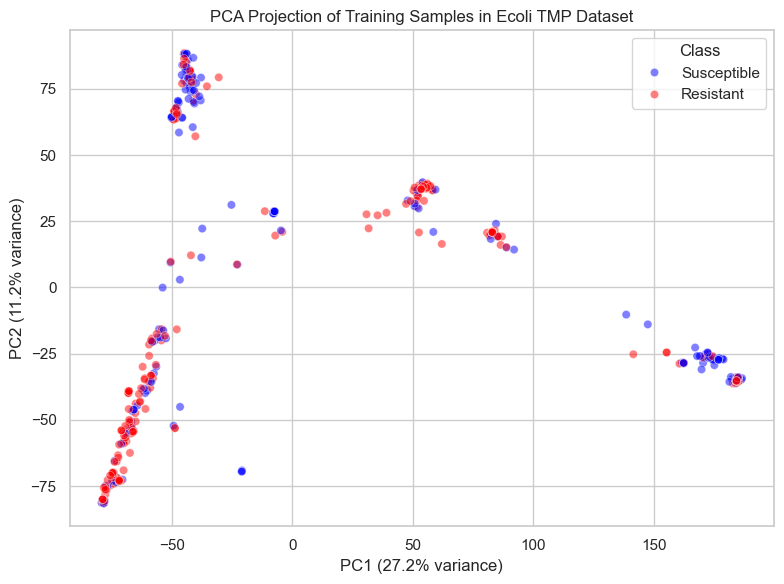

In [14]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_resampled_tmp)

explained = pca.explained_variance_ratio_
import seaborn as sns
sns.set(style="whitegrid")

df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df['Label'] = ['Susceptible' if i == 0 else 'Resistant' for i in y_train_resampled_tmp]

plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='PC1', y='PC2', hue='Label', palette={'Susceptible': 'blue', 'Resistant': 'red'}, alpha=0.5)
plt.title("PCA Projection of Training Samples in Ecoli TMP Dataset")
plt.xlabel(f"PC1 ({explained[0]*100:.1f}% variance)")
plt.ylabel(f"PC2 ({explained[1]*100:.1f}% variance)")
plt.legend(title='Class')
plt.tight_layout()


##### 2. CTX

Accuracy on test set: 0.9556
Accuracy on training set: 1.0000
              precision    recall  f1-score   support

           0       0.86      0.95      0.90        39
           1       0.99      0.96      0.97       141

    accuracy                           0.96       180
   macro avg       0.92      0.95      0.94       180
weighted avg       0.96      0.96      0.96       180



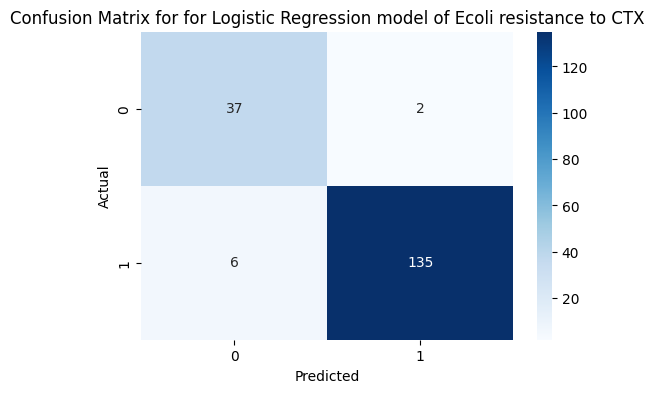

ROC-AUC on test set: 0.982


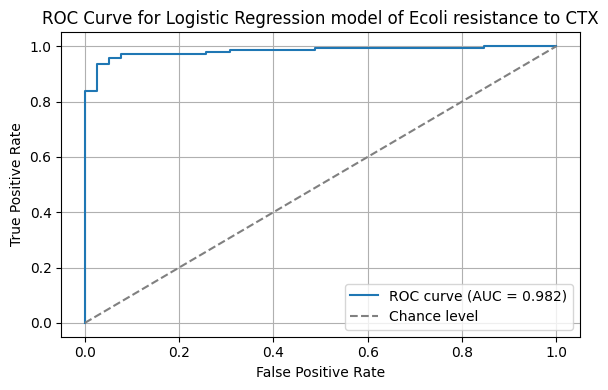

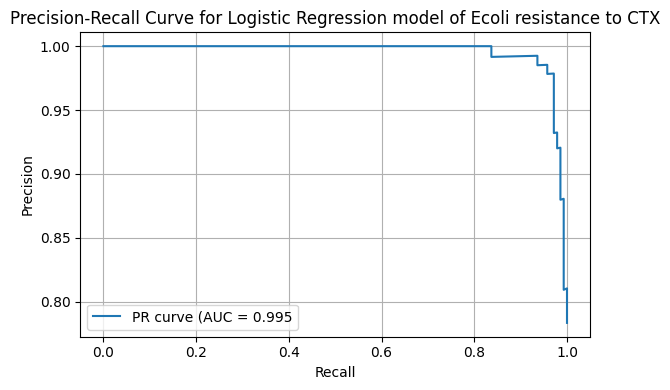

In [10]:
model_ctx = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42, C=1)

# Train the model
model_ctx.fit(X_train_resampled_ctx, y_train_resampled_ctx)

# Predictions
y_pred = model_ctx.predict(X_test_ctx)
y_train_pred = model_ctx.predict(X_train_resampled_ctx)

# Probabilities for ROC and PR curves
y_prob = model_ctx.predict_proba(X_test_ctx)[:, 1]  # Probability for the positive class

# Accuracy scores
print(f"Accuracy on test set: {accuracy_score(y_test_ctx, y_pred):.4f}")
print(f"Accuracy on training set: {accuracy_score(y_train_resampled_ctx, y_train_pred):.4f}")

# Classification report and confusion matrix
print(classification_report(y_test_ctx, y_pred))
cm = confusion_matrix(y_test_ctx, y_pred)

# Display confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix for for Logistic Regression model of Ecoli resistance to CTX")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC-AUC score
roc_auc = roc_auc_score(y_test_ctx, y_prob)
print(f"ROC-AUC on test set: {roc_auc:.3f}")

# Plot ROC-AUC Curve 
fpr, tpr, _ = roc_curve(y_test_ctx, y_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Chance level')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Logistic Regression model of Ecoli resistance to CTX")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Precision-Recall Curve 
precision, recall, _ = precision_recall_curve(y_test_ctx, y_prob)
pr_auc = average_precision_score(y_test_ctx, y_prob)
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.3f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Logistic Regression model of Ecoli resistance to CTX")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


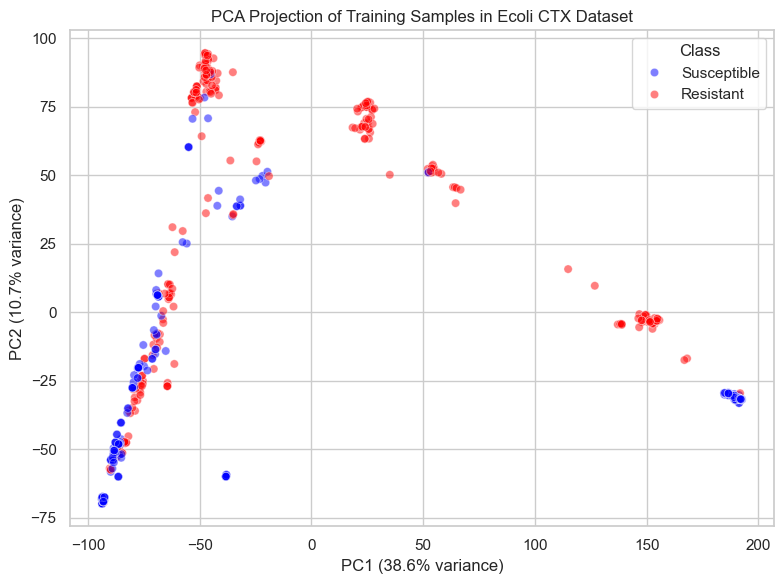

In [16]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_resampled_ctx)

explained = pca.explained_variance_ratio_
import seaborn as sns
sns.set(style="whitegrid")

df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df['Label'] = ['Susceptible' if i == 0 else 'Resistant' for i in y_train_resampled_ctx]

plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='PC1', y='PC2', hue='Label', palette={'Susceptible': 'blue', 'Resistant': 'red'}, alpha=0.5)
plt.title("PCA Projection of Training Samples in Ecoli CTX Dataset")
plt.xlabel(f"PC1 ({explained[0]*100:.1f}% variance)")
plt.ylabel(f"PC2 ({explained[1]*100:.1f}% variance)")
plt.legend(title='Class')
plt.tight_layout()


##### 3. SUL

Accuracy on test set: 0.8500
Accuracy on training set: 1.0000
              precision    recall  f1-score   support

           0       0.85      0.87      0.86        95
           1       0.85      0.82      0.84        85

    accuracy                           0.85       180
   macro avg       0.85      0.85      0.85       180
weighted avg       0.85      0.85      0.85       180

ROC-AUC on test set: 0.9069


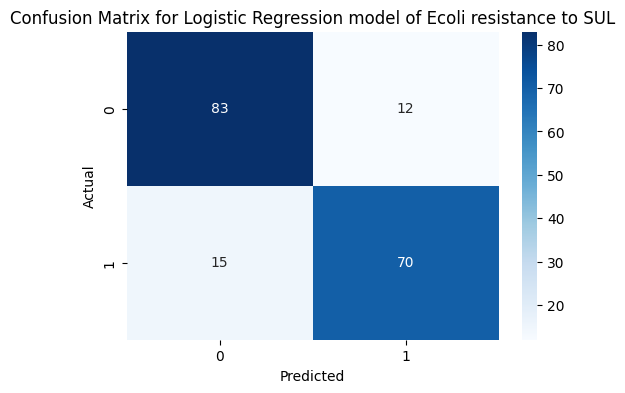

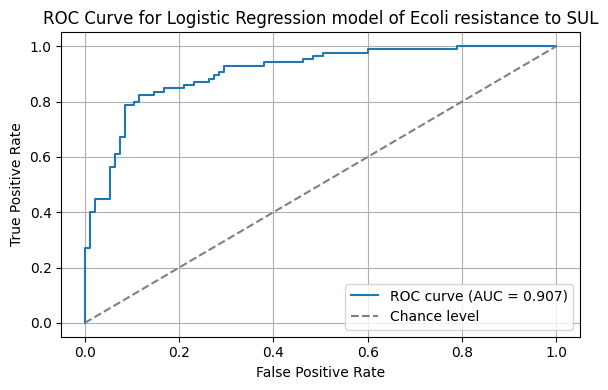

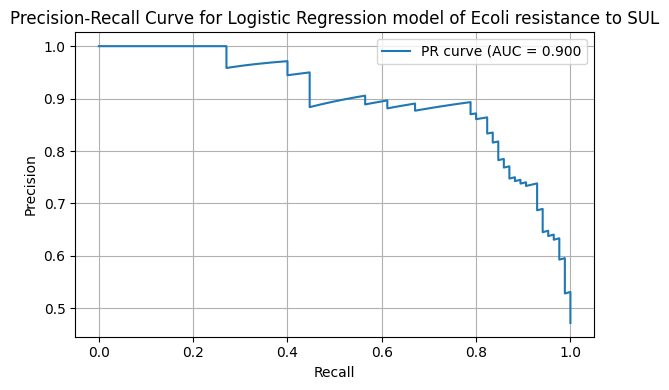

In [11]:
model_sul = LogisticRegression(max_iter=500, class_weight='balanced', random_state=42, C=1)

# Train the model
model_sul.fit(X_train_sul, y_train_sul)

# Predictions
y_pred = model_sul.predict(X_test_sul)
y_train_pred = model_sul.predict(X_train_sul)

# Probabilities for ROC and PR curves
y_prob = model_sul.predict_proba(X_test_sul)[:, 1]  # Probability for the positive class

# Accuracy scores
print(f"Accuracy on test set: {accuracy_score(y_test_sul, y_pred):.4f}")
print(f"Accuracy on training set: {accuracy_score(y_train_sul, y_train_pred):.4f}")

# Classification report and confusion matrix
print(classification_report(y_test_sul, y_pred))

# ROC-AUC score
roc_auc = roc_auc_score(y_test_sul, y_prob)
print(f"ROC-AUC on test set: {roc_auc:.4f}")

# Display confusion matrix
cm = confusion_matrix(y_test_sul, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix for Logistic Regression model of Ecoli resistance to SUL")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Plot ROC-AUC Curve 
fpr, tpr, _ = roc_curve(y_test_sul, y_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Chance level')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Logistic Regression model of Ecoli resistance to SUL")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Precision-Recall Curve 
precision, recall, _ = precision_recall_curve(y_test_sul, y_prob)
pr_auc = average_precision_score(y_test_sul, y_prob)

plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.3f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Logistic Regression model of Ecoli resistance to SUL")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


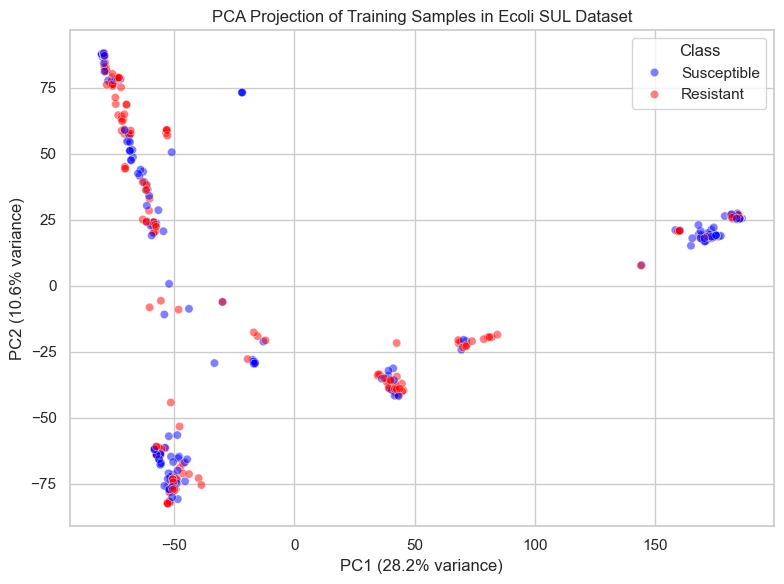

In [19]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_sul)

explained = pca.explained_variance_ratio_
import seaborn as sns
sns.set(style="whitegrid")

df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df['Label'] = ['Susceptible' if i == 0 else 'Resistant' for i in y_train_sul]

plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='PC1', y='PC2', hue='Label', palette={'Susceptible': 'blue', 'Resistant': 'red'}, alpha=0.5)
plt.title("PCA Projection of Training Samples in Ecoli SUL Dataset")
plt.xlabel(f"PC1 ({explained[0]*100:.1f}% variance)")
plt.ylabel(f"PC2 ({explained[1]*100:.1f}% variance)")
plt.legend(title='Class')
plt.tight_layout()


### Regression coefficients

##### 1. TMP

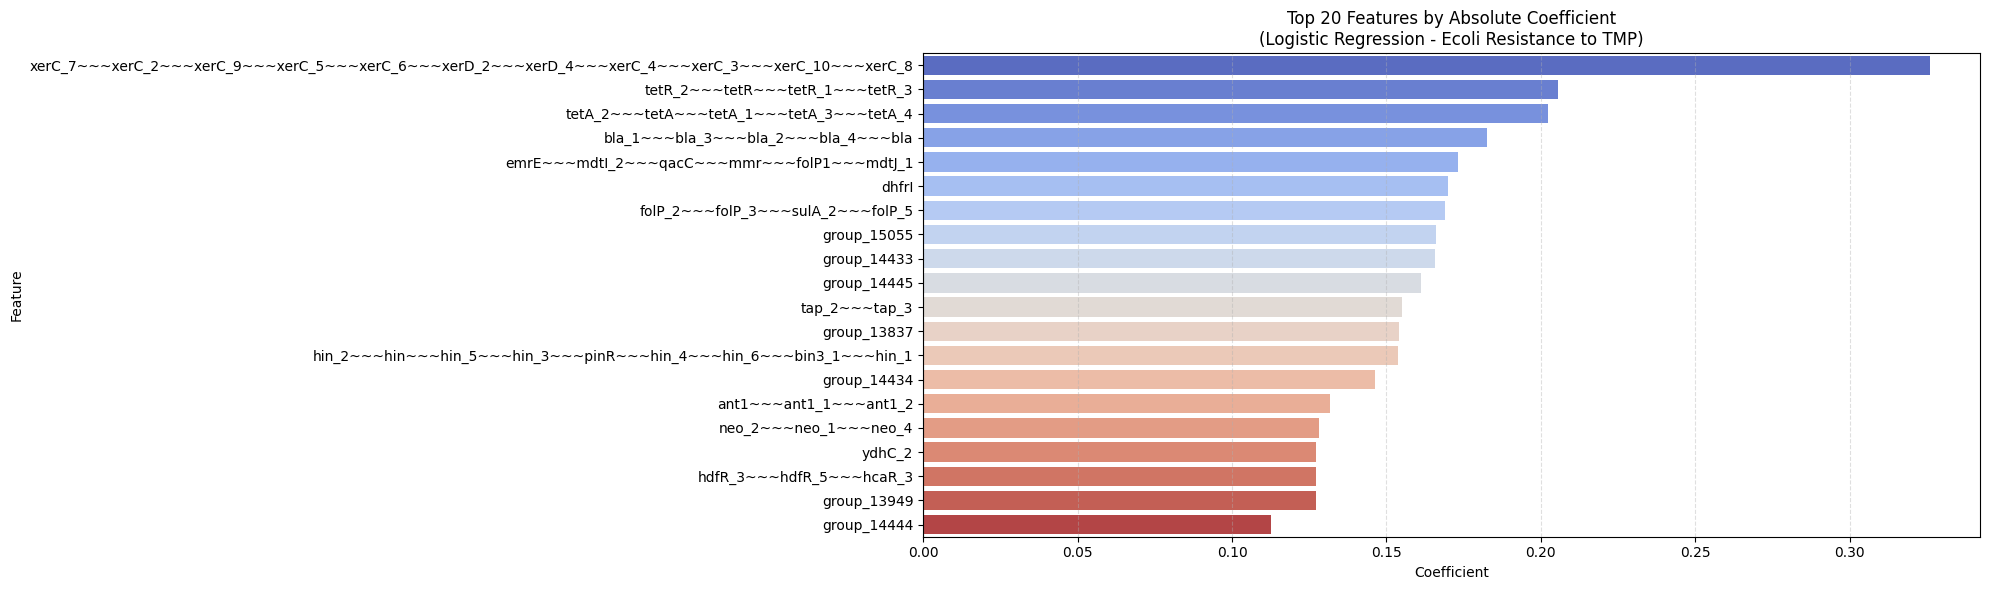

In [13]:
# Extract coefficients and feature names
coef = model_tmp.coef_[0]
features = X_noST.columns

# Create DataFrame
coef_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': coef,
    'Odds Ratio': np.exp(coef),
    'Abs Coefficient': np.abs(coef)
})

# Sort by absolute coefficient value
coef_df_sorted = coef_df.sort_values(by='Abs Coefficient', ascending=False).head(20)

# Plot
plt.figure(figsize=(20, 6))
plt.grid(axis='x', linestyle='--', alpha=0.4)
sns.barplot(
    data=coef_df_sorted,
    y='Feature',
    x='Coefficient',
    palette='coolwarm',
    hue='Feature'
)
plt.axvline(0, color='gray', linestyle='--')

plt.title('Top 20 Features by Absolute Coefficient\n(Logistic Regression - Ecoli Resistance to TMP)')
plt.tight_layout()
plt.show()


##### 2. CTX

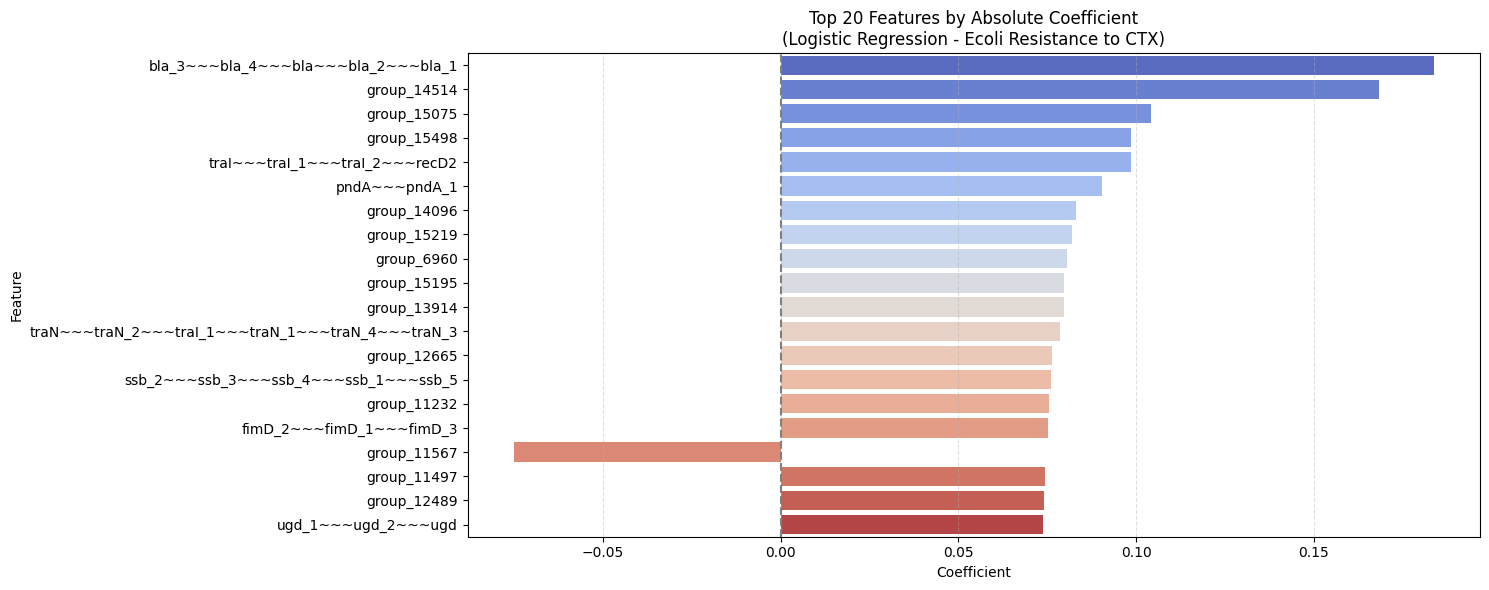

In [15]:
# Extract coefficients and feature names
coef = model_ctx.coef_[0]
features = X_noST.columns

# Create DataFrame
coef_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': coef,
    'Odds Ratio': np.exp(coef),
    'Abs Coefficient': np.abs(coef)
})

# Sort by absolute coefficient value
coef_df_sorted = coef_df.sort_values(by='Abs Coefficient', ascending=False).head(20)

# Plot
plt.figure(figsize=(15, 6))
plt.grid(axis='x', linestyle='--', alpha=0.4)
sns.barplot(
    data=coef_df_sorted,
    y='Feature',
    x='Coefficient',
    palette='coolwarm',
    hue='Feature'
)
plt.axvline(0, color='gray', linestyle='--')

plt.title('Top 20 Features by Absolute Coefficient\n(Logistic Regression - Ecoli Resistance to CTX)')
plt.tight_layout()
plt.show()


##### 3. SUL

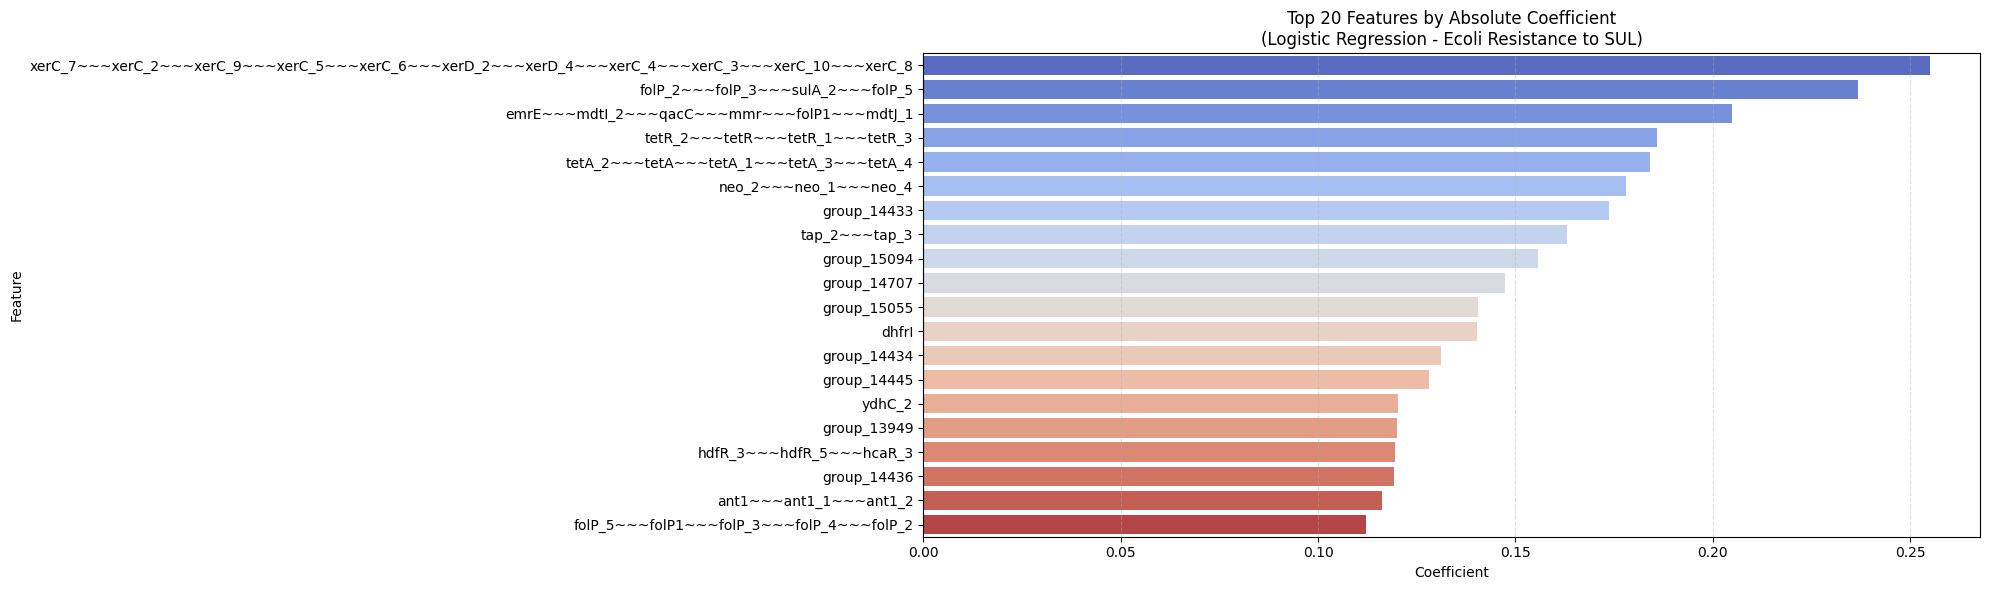

In [17]:
# Extract coefficients and feature names
coef = model_sul.coef_[0]
features = X_noST.columns

# Create DataFrame
coef_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': coef,
    'Odds Ratio': np.exp(coef),
    'Abs Coefficient': np.abs(coef)
})

# Sort by absolute coefficient value
coef_df_sorted = coef_df.sort_values(by='Abs Coefficient', ascending=False).head(20)

# Plot
plt.figure(figsize=(20, 6))
plt.grid(axis='x', linestyle='--', alpha=0.4)
sns.barplot(
    data=coef_df_sorted,
    y='Feature',
    x='Coefficient',
    palette='coolwarm',
    hue='Feature'
)
plt.axvline(0, color='gray', linestyle='--')

plt.title('Top 20 Features by Absolute Coefficient\n(Logistic Regression - Ecoli Resistance to SUL)')
plt.tight_layout()
plt.show()
